In [1]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import seaborn as sns

# función propia de agrepación de datos censales por tramos de edad
from functions.agrupar_dfs_censo import agrupar_por_tramos
from functions.cargar_data import cargar_censo

In [2]:
# vector para usar en metadatos del PDF exportado
metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

In [3]:
# levanta datos censales
censo = cargar_censo()

In [4]:
censo.head(2)

,DPTO,LOC,SECC,SEGM,PERPH02,PERNA01,PERNA02,PERMI01,PERMI01_1,PERMI01_2,...,PERED02_4,PERED03_R,PERED03_1,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R
0,1,20,1,1,2,22.0,1988-11-01,1,NaN,NaN,...,0,0,4,0,1,3,0,22101,1,4
1,1,20,1,1,2,84.0,1927-07-01,1,NaN,NaN,...,0,0,2,0,2,2,0,11101,2,2


#### Subset del DF Censo, sólo con los migrantes internos

In [5]:
def filter_df_censo(df):
    "Filtra DF del censo quedándose unicamente con los migrantes recientes"
    # un primer análisis abarcando sólo aquellas personas que han migrado entre departamentos
    # (no toma en cuenta quienes han migrado otras localidades dentro del mismo departamento)
    mgr = df.loc[df.PERMI07 == 3].reset_index(drop=True)
    # identifica depto de residencia anterior, creando var "depto_origen"
    mgr.insert(0, 'depto_origen', mgr.loc[:,('PERMI07_2')])
    # convierte a integer
    mgr.loc[:,('depto_origen')] = mgr.loc[:,('depto_origen')].astype(int)
    # renombra DPTO
    mgr.rename(columns={'DPTO': 'depto_destino'}, inplace=True)

    return mgr

In [6]:
mgr_interdep = filter_df_censo(censo)
mgr_interdep.head()

,depto_origen,depto_destino,LOC,SECC,SEGM,PERPH02,PERNA01,PERNA02,PERMI01,PERMI01_1,...,PERED02_4,PERED03_R,PERED03_1,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R
0,3,1,20,1,1,1,24.0,1987-05-01,1,NaN,...,0,0,11,0,2,3,4,55131,1,9
1,17,1,20,1,1,2,22.0,1988-11-01,3,NaN,...,0,11,0,0,0,2,4,55152,1,9
2,18,1,20,1,1,1,19.0,1992-03-01,3,NaN,...,0,0,6,0,2,2,0,33101,1,5
3,2,1,20,1,1,1,24.0,1986-12-01,3,NaN,...,0,0,6,0,2,1,0,33101,1,5
4,12,1,20,1,1,2,28.0,1982-11-01,3,NaN,...,0,0,4,0,2,1,0,22101,1,4


#### Agrupación de ambos DFs

In [7]:
censo_group, migrantes_group = [agrupar_por_tramos(x,'tramo', 'PERNA01','PERPH02') for x in [censo, mgr_interdep]]

In [8]:
print(censo_group.head())
print(migrantes_group.head())

   sexo  tramo  personas  porc_pers sexo_label
0     1    +95      -806  -0.024530    varones
1     1    0-4   -112701  -3.429916    varones
2     1  10-14   -131018  -3.987371    varones
3     1  15-19   -133041  -4.048939    varones
4     1  20-24   -119928  -3.649861    varones
   sexo  tramo  personas  porc_pers sexo_label
0     1    +95       -21  -0.014117    varones
1     1  10-14     -5234  -3.518443    varones
2     1  15-19     -6785  -4.561069    varones
3     1  20-24    -11190  -7.522234    varones
4     1  25-29     -8301  -5.580167    varones


In [9]:
# vector de etiquetas para cada tramo
y_labels = ['+95','90-94','85-89','80-84','75-79','70-74',
            '65-69','60-64','55-59','50-54','45-49','40-44',
            '35-39','30-34','25-29','20-24','15-19','10-14',
            '5-9','0-4']

colors = ['skyblue', 'seagreen']

# función para graficar
def bars_pyramid(df, axis, col_agrup, colors, bar_order):
    "Grafica barras para pirámdes"
    for c, group in zip(colors, df[col_agrup].unique()):
        sns.barplot(x='porc_pers',
                    y='tramo',
                    data=df.loc[df[col_agrup]==group, :],
                    order = bar_order,
                    color=c,
                    ax=axis)

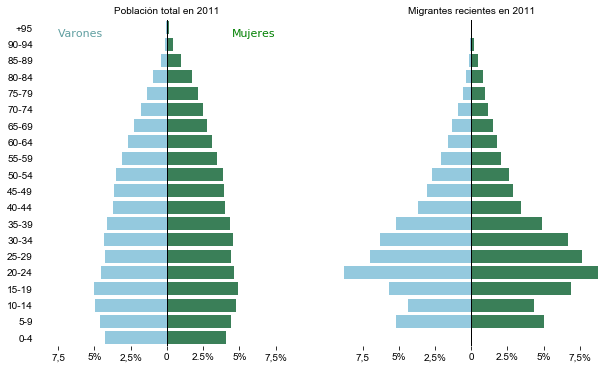

In [10]:
# pirámides de población

# dos ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= (10, 6), sharex=True, sharey='row')

# setea tipo de fuente y tamaño
size = 10
font = {'fontname': 'Arial', 'fontsize': size}

# aplica función para graficar
bars_pyramid(censo_group, ax1, 'sexo_label', colors, y_labels)
bars_pyramid(migrantes_group, ax2, 'sexo_label', colors, y_labels)

ax1.set_title('Población total en 2011', **font)
ax2.set_title('Migrantes recientes en 2011', **font)

# etiquetas
x_ticks_labels = ['10','7,5','5%','2,5%','0','2.5%','5%','7,5%']
ax1.set_yticklabels(y_labels, **font)

# parámetros gráficos
def param_graficos(axes, xlim, x_ticks_labels):
    "Setea parámetros gráficos"
    axes.set_axisbelow(True)
    axes.set_ylabel(None)
    axes.set_xlabel(None)
    axes.axvline(linewidth=1, color='black')
    axes.set_xticklabels(x_ticks_labels, **font)
    [s.set_visible(False) for s in axes.spines.values()]
    [t.set_visible(False) for t in axes.get_yticklines()]
    axes.set_xlim([-xlim,xlim])
    
[param_graficos(i, 7, x_ticks_labels) for i in [ax1, ax2]]

# etiqueta sexos
def etiquetar_sexos(x_position, y_position, ax_name, colors, font_size):
        # Varones
        ax_name.text(x_position*-1, y_position, 'Varones',
        horizontalalignment='left',
        color=colors[0], fontsize=font_size)
        # Mujeres
        ax_name.text(x_position, y_position, 'Mujeres',
        horizontalalignment='right',
        color=colors[1], fontsize=font_size)

etiquetar_sexos(6, 0.5, ax1, ['cadetblue', 'green'], 11)

plt.savefig('mapas_graficas/001_poblacion_vs_migrantes.pdf',
             bbox_inches= 'tight',
             metadata= metadatos_figs)

plt.show()

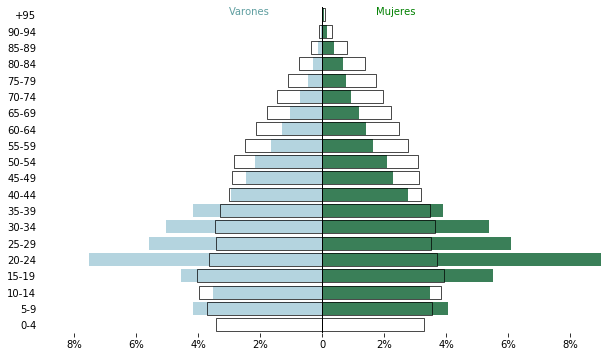

In [11]:
# pirámides de población solapadas
fig, ax  = plt.subplots(1, figsize= ( 10, 6 ))

# plot
group_col = 'sexo_label'
order_of_bars = y_labels
colors = ['lightblue', 'seagreen']
label=['sexo', '']

bars_pyramid(migrantes_group, ax, 'sexo_label', colors, y_labels)

for c, group in zip(colors, migrantes_group[group_col].unique()):
    sns.barplot(x='porc_pers', y='tramo',
                data=censo_group.loc[censo_group[group_col]==group, :],
                order = order_of_bars,
                fill=False,
                linewidth = 0.7,
                edgecolor='black',
                ax=ax)    
    
ax.set_axisbelow(True)
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.axvline(linewidth=1, color='black')
ax.set_xlim([-9,9])
ax.set_xticklabels(['10%','8%','6%','4%','2%','0','2%','4%','6%','8%'])

[s.set_visible(False) for s in ax.spines.values()]
[t.set_visible(False) for t in ax.get_yticklines()]

etiquetar_sexos(3, 0, ax, ['cadetblue', 'green'], 10)

plt.savefig('mapas_graficas/piramide_mig.pdf',
             bbox_inches='tight',
             metadata = metadatos_figs)

plt.show()

In [12]:
# destino Mvdeo.
a = mgr_interdep[mgr_interdep.depto_destino == 1]

# origen Mvdeo. y destino no Mvdeo.
b = mgr_interdep[(mgr_interdep.depto_origen == 1) & (mgr_interdep.depto_destino != 1)]

# origen y destino no Mvdeo.
c = mgr_interdep[(mgr_interdep.depto_origen != 1) & (mgr_interdep.depto_destino != 1)]

# enlista los tres dataframes
lista_dfs = [a, b, c]

In [13]:
mgr_interdep.head()

,depto_origen,depto_destino,LOC,SECC,SEGM,PERPH02,PERNA01,PERNA02,PERMI01,PERMI01_1,...,PERED03_R,PERED03_1,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R,tramo
0,3,1,20,1,1,1,24.0,1987-05-01,1,NaN,...,0,11,0,2,3,4,55131,1,9,20-24
1,17,1,20,1,1,2,22.0,1988-11-01,3,NaN,...,11,0,0,0,2,4,55152,1,9,20-24
2,18,1,20,1,1,1,19.0,1992-03-01,3,NaN,...,0,6,0,2,2,0,33101,1,5,15-19
3,2,1,20,1,1,1,24.0,1986-12-01,3,NaN,...,0,6,0,2,1,0,33101,1,5,20-24
4,12,1,20,1,1,2,28.0,1982-11-01,3,NaN,...,0,4,0,2,1,0,22101,1,4,25-29


In [14]:
# genera dataframes por tipología
def filter_df_mig(df, ver_dep_ori, var_dep_des):
    "Corta DFs según origen y destino de la migración"
    # destino Mvdeo.
    a = df[df[var_dep_des] == 1].copy()
    # origen Mvdeo. y destino no Mvdeo.
    b = df[(df[ver_dep_ori] == 1) & (df[var_dep_des] != 1)].copy()
    # origen y destino no Mvdeo.
    c = df[(df[ver_dep_ori] != 1) & (df[var_dep_des] != 1)].copy()
    
    return a, b, c

# aplica función
a, b, c = filter_df_mig(mgr_interdep, 'depto_origen', 'depto_destino')

# enlista los tres DFs
lista_dfs = [a, b, c]

# agrupa los tres DFs
a_group, b_group, c_group = [agrupar_por_tramos(x, 'tramo', 'PERNA01', 'PERPH02') for x in lista_dfs]

# vector de titulos de gráficas
titles = ['Hacia Montevideo',
          'Desde Montevideo al interior',
          'Entre departamentos del interior']

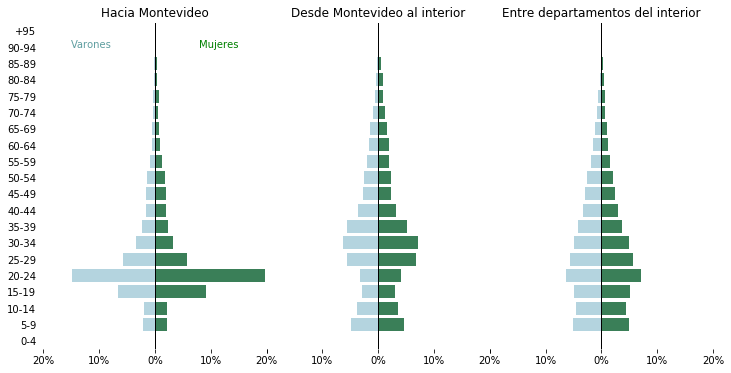

In [15]:
# pirámides de población
# tres ejes
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize= (12, 6), sharex=False, sharey='row')

plt.subplots_adjust(wspace=0)

# plot
lista_dfs = [a_group, b_group, c_group]
axes = [ax1, ax2, ax3]

[bars_pyramid(lista_dfs[i], axes[i], 'sexo_label', colors, y_labels) for i in range(3)]

[axes[i].set_title(titles[i]) for i in range(3)]

for i in axes:
    i.set_axisbelow(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])
    i.set_xlabel(None)
    i.set_ylabel(None)
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]

x_ticks_labels = ['20%','10%','0%','10%','20%']

ax1.set_xticklabels(x_ticks_labels)
ax2.set_xticklabels(['','10%','0%','10%',''])
ax3.set_xticklabels(x_ticks_labels)

etiquetar_sexos(15, 1, ax1, ['cadetblue', 'green'], 10)

plt.savefig('mapas_graficas/piramides_mig_recientes.pdf',
             bbox_inches='tight',
             metadata = metadatos_figs)

plt.show()

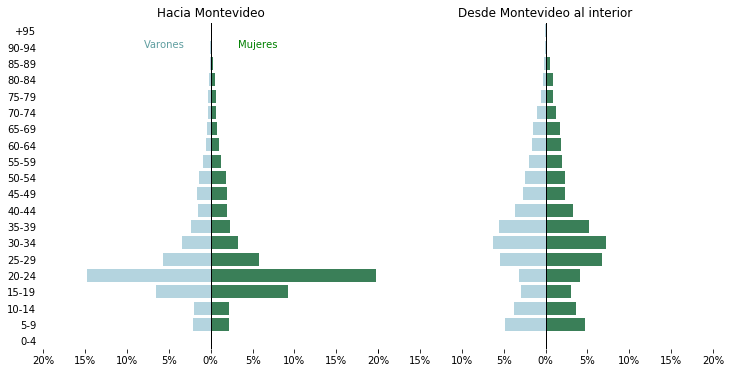

In [16]:
# pirámides de población

# dos ejes
fig, (ax1, ax2)  = plt.subplots(1,2, figsize= ( 12, 6 ), sharex= False, sharey='row')

plt.subplots_adjust(wspace=0)

# plot
lista_dfs = [a_group, b_group]
axes = [ax1, ax2]

[bars_pyramid(lista_dfs[i], axes[i], 'sexo_label', colors, y_labels) for i in range(2)]

[axes[i].set_title(titles[i]) for i in range(2)]


for i in axes:
    i.set_ylabel(None)
    i.set_xlabel(None)
    i.set_axisbelow(True)
    i.axvline(linewidth=1, color='black')
    i.set_xlim([-20,20])
    [s.set_visible(False) for s in i.spines.values()]
    [t.set_visible(False) for t in i.get_yticklines()]
    
x_ticks_labels = ['20%','15%','10%','5%','0%','5%','10%','15%','20%']

ax1.set_xticklabels(x_ticks_labels)
ax2.set_xticklabels([''] + x_ticks_labels[1:])

etiquetar_sexos(8, 1, ax1, ['cadetblue', 'green'], 10)

plt.savefig('mapas_graficas/004_piramides_mig_recientes_desde_a_mvdeo.pdf',
             bbox_inches='tight',
             metadata= metadatos_figs )

plt.show()